In [109]:
 ! pip install catboost

In [110]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline 
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split



from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor
from sklearn.metrics import explained_variance_score

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


In [111]:
train_data = pd.read_csv("../input/carprice/carprice/train.csv")
test_data = pd.read_csv("../input/carprice/carprice/test.csv")
submission_data = pd.read_csv("../input/carprice/carprice/submission.csv")

In [112]:
train_price = train_data["Price"]
train_data.drop("Price",axis=1,inplace=True)
train_data["Price"] = train_price

In [113]:
display(train_data.head())
display(test_data.head())
display(submission_data.head())

,ID,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Price
0,45654403,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12,13328
1,44731507,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8,16621
2,45774419,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2,8467
3,45769185,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0,3607
4,45809263,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4,11726


,ID,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Price
0,44020629,-,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,2.0 Turbo,0 km,4,Manual,Front,02-Mar,Left wheel,Grey,10,NaN
1,45784798,-,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,2.4,26000 km,4,Tiptronic,Front,04-May,Left wheel,Grey,10,NaN
2,45800257,-,NISSAN,Tiida,2005,Sedan,No,Petrol,1.5,168000 km,4,Automatic,Front,04-May,Right-hand drive,Sky blue,8,NaN
3,45797981,975,VOLVO,XC90,2012,Jeep,Yes,Petrol,3.2,143000 km,6,Automatic,4x4,04-May,Left wheel,Blue,12,NaN
4,45814303,-,OPEL,Astra,1993,Hatchback,No,Petrol,1.6,200000 km,4,Manual,Front,04-May,Left wheel,Black,0,NaN


,Price
0,0
1,0
2,0
3,0
4,0


In [114]:
print(train_data.shape)
print(test_data.shape)

(19237, 18)
(8245, 18)


In [115]:
# sub_data = pd.DataFrame(({"Price" :[10000]*8245 }))
# sub_data.to_csv("sample_submission_check.csv",index=False)

In [116]:
def column_details(df):
  cat = []
  num = []
  for i in df.columns:
    if df[i].dtypes==object:
        cat.append(i)
    else:
        num.append(i)
  print('The numerical data are {}'.format(num))
  print('The categorical data are {}'.format(cat))
  return num,cat

num_col,cat_col = column_details(train_data)

The numerical data are ['ID', 'Prod. year', 'Cylinders', 'Airbags', 'Price']
The categorical data are ['Levy', 'Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color']


In [117]:
full_data = pd.concat([train_data,test_data],axis=0)

In [118]:
print(train_data.shape)
print(test_data.shape)
print(full_data.shape)

(19237, 18)
(8245, 18)
(27482, 18)


In [119]:
full_data.head()

,ID,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Price
0,45654403,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12,13328.0
1,44731507,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8,16621.0
2,45774419,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2,8467.0
3,45769185,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0,3607.0
4,45809263,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4,11726.0


In [120]:
# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

In [121]:
full_data['Prod. year']=full_data['Prod. year'].astype(object)

full_data["Mileage"]=full_data['Mileage'].replace({'1234567899 km':"0 km"})
full_data['Mileage']=full_data['Mileage'].str.replace('km','')
full_data['Mileage']=full_data['Mileage'].astype(int)

full_data['Doors']=full_data['Doors'].replace({'04-May':4,'02-Mar':2})
full_data['Doors']=full_data['Doors'].astype(str)

full_data['Levy']=full_data['Levy'].replace({'-':np.nan})
full_data['Levy']=full_data['Levy'].astype(float)

full_data["Cylinders"]=full_data["Cylinders"].replace({127.0:12})
full_data['Cylinders']=full_data['Cylinders'].astype(str)

full_data['Turbo engine']=full_data['Engine volume'].replace(['2.0 Turbo', '2.2 Turbo','3.0 Turbo','1.4 Turbo','1.5 Turbo', '1.6 Turbo','2.3 Turbo','2.8 Turbo','1.8 Turbo', '2.4 Turbo', '3.5 Turbo', '3.2 Turbo','1.3 Turbo','2.5 Turbo','1.9 Turbo', '4.4 Turbo', '4.7 Turbo', '0.2 Turbo','4.8 Turbo', '4.6 Turbo','1.2 Turbo','1.7 Turbo', '6.3 Turbo', '2.7 Turbo','2.9 Turbo', '4.0 Turbo','3.6 Turbo','3.7 Turbo','5.5 Turbo','2.1 Turbo','0.7 Turbo', '0.6 Turbo','1.0 Turbo', '4.5 Turbo', '0.8 Turbo', '4.2 Turbo', '3.1', '5.0 Turbo','5.7 Turbo','0.4 Turbo', '5.4 Turbo', '0.3 Turbo','1.1 Turbo','2.6 Turbo','6.0 Turbo'],'Turbo')
full_data['Turbo engine']=full_data['Turbo engine'].replace(['3.5','3','1.3','2.5','2','1.8','2.4','4','1.6','3.3','4.7','1.5','4.4','3.6','2.3','2.2','1.4','5.5','3.2','3.8','4.6','1.2','5', '1.7', '2.9', '0.5','1.9','2.7','4.8','5.3','0.4','2.8','1.1','2.1','0.7','5.4','3.7','1','2.6','5.7','3.4','4.3','4.2','5.9','6.8','4.5','0.6','7.3','0.1','6.3','6.4','5.2','5.8','0.8', '6.7', '6.2', '0', '20', '0.3', '0.2','5.6', '6', '3.9', '0.9','6.1','6.6','10.8'],'No')
full_data['Turbo engine'] = full_data['Turbo engine'].replace("Turbo","Yes")

full_data['Engine volume']=full_data['Engine volume'].str.replace('Turbo','')
full_data['Engine volume']=full_data['Engine volume'].astype(float)

full_data['Drive wheels']=full_data['Drive wheels'].replace({'4x4':'4-WD'})

full_data["Airbags"] = full_data["Airbags"].astype(str)

full_data["Price"] = full_data["Price"].replace({26307500.0:26307.0})

# full_data['Costly car'] = full_data['Price'].apply(lambda x: 1 if x >= 100000 else 0)

In [122]:
full_data['Mileage'] = full_data['Mileage'].apply(lambda x: x if x <= 500000.0 else 0)

full_data["Mileage"] = full_data["Mileage"].replace(0,full_data["Mileage"].mean())

full_data['Levy'] = full_data['Levy'].fillna(full_data['Levy'].mean())

In [123]:
full_data.drop(["ID","Price","Manufacturer","Model"],axis=1,inplace=True)

In [124]:
full_data_copy = full_data.copy()

In [125]:
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
for col in full_data_copy.columns.values:
    if full_data_copy.loc[:,col].dtype == "object":
        lbl.fit(full_data_copy.loc[:,col].astype(str))
        full_data_copy.loc[:,col] = lbl.transform(full_data_copy.loc[:,col].astype(str))
        # test.loc[:,col] = lbl.transform(test.loc[:,col].astype(str))

In [126]:
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
for col in full_data_copy.columns.values:
    if full_data_copy.loc[:,col].dtype == "object":
        lbl.fit(full_data_copy.loc[:,col].astype(int64))
        full_data_copy.loc[:,col] = lbl.transform(full_data_copy.loc[:,col].astype(int64))
        # test.loc[:,col] = lbl.transform(test.loc[:,col].astype(str))

In [127]:
full_data_copy.head()

,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo engine
0,1399.000000,48,4,1,2,3.5,186005.0,11,0,0,1,0,12,4,0
1,1018.000000,49,4,0,5,3.0,192000.0,11,2,0,1,0,1,15,0
2,910.160914,44,3,0,5,1.3,200000.0,9,3,1,1,1,1,9,0
3,862.000000,49,4,1,2,2.5,168966.0,9,0,0,1,0,14,0,0
4,446.000000,52,3,1,5,1.3,91901.0,9,0,1,1,0,12,11,0


In [128]:
full_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27482 entries, 0 to 8244
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Levy              27482 non-null  float64
 1   Prod. year        27482 non-null  int64  
 2   Category          27482 non-null  int64  
 3   Leather interior  27482 non-null  int64  
 4   Fuel type         27482 non-null  int64  
 5   Engine volume     27482 non-null  float64
 6   Mileage           27482 non-null  float64
 7   Cylinders         27482 non-null  int64  
 8   Gear box type     27482 non-null  int64  
 9   Drive wheels      27482 non-null  int64  
 10  Doors             27482 non-null  int64  
 11  Wheel             27482 non-null  int64  
 12  Color             27482 non-null  int64  
 13  Airbags           27482 non-null  int64  
 14  Turbo engine      27482 non-null  int64  
dtypes: float64(3), int64(12)
memory usage: 3.4 MB


In [129]:
full_data_copy.columns

Index(['Levy', 'Prod. year', 'Category', 'Leather interior', 'Fuel type',
       'Engine volume', 'Mileage', 'Cylinders', 'Gear box type',
       'Drive wheels', 'Doors', 'Wheel', 'Color', 'Airbags', 'Turbo engine'],
      dtype='object')

In [130]:
sc = StandardScaler()
full_data_copy_sc = pd.DataFrame(sc.fit_transform(full_data_copy))
# test_sc = pd.DataFrame(sc.fit_transform(test))

In [131]:
full_data_copy_sc.columns = full_data_copy.columns

In [132]:
full_data_copy_sc.shape

(27482, 15)

In [133]:
full_data_copy_sc.head()

,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo engine
0,1.282596,-0.166025,-0.817229,0.615795,-0.793472,1.346803,0.525957,1.163112,-0.599015,-1.599316,0.160242,-0.287490,0.790596,-0.717521,-0.334262
1,0.282944,0.014198,-0.817229,-1.623918,0.867362,0.779438,0.595723,1.163112,1.633895,-1.599316,0.160242,-0.287490,-1.259927,1.553387,-0.334262
2,0.000000,-0.886914,-1.175834,-1.623918,0.867362,-1.149602,0.688821,-0.426576,2.750351,0.159765,0.160242,3.478382,-1.259927,0.314710,-0.334262
3,-0.126363,0.014198,-0.817229,0.615795,-0.793472,0.212073,0.327668,-0.426576,-0.599015,-1.599316,0.160242,-0.287490,1.163418,-1.543306,-0.334262
4,-1.217846,0.554865,-1.175834,0.615795,0.867362,-1.149602,-0.569162,-0.426576,-0.599015,0.159765,0.160242,-0.287490,0.790596,0.727602,-0.334262


In [134]:
train = full_data_copy_sc.iloc[:19237]
test = full_data_copy_sc.iloc[19237:]

In [135]:
# display(train.tail())
# display(train_data.tail())

# display(test.head())
# display(test_data.head())

# print(test.shape)
# print(test_data.shape)

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor
from sklearn.metrics import explained_variance_score

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import Ridge,Lasso

import statsmodels
import statsmodels.api

In [137]:
X = train
y = train_price
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [138]:
# xgb = XGBRegressor()
# xgb.fit(X_train,y_train)
# y_pred = xgb.predict(X_test)
# print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
# print("Mean Squared Error is",mean_squared_error(y_test,y_pred))
# print("R squared Score is",r2_score(y_test,y_pred))
# print("Mean Absolute Logarithmic Error is",np.sqrt(mean_squared_log_error(y_test,y_pred)))

In [139]:
# xgb.fit(X,y)
# y_pred_test = xgb.predict(test)
# price_sub = pd.DataFrame({"Price":np.abs(y_pred_test)})
# price_sub.to_csv("submission_1_xbg_carprice.csv",index = False)
# price_sub.head()

In [140]:
# x_train.insert(loc=0,column='intercept',value=np.ones(x_train.shape[0]))

In [141]:
x_train.head()

,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo engine
7808,-0.344135,0.374642,0.975797,0.615795,-0.793472,0.212073,0.985689,-0.426576,-0.599015,0.159765,0.160242,-0.28749,1.163418,-0.717521,-0.334262
16766,0.975616,-0.706692,-0.817229,0.615795,-1.347084,-0.355292,-0.751903,-0.426576,-0.599015,0.159765,0.160242,-0.28749,0.790596,0.727602,-0.334262
7285,1.282596,-0.166025,0.975797,0.615795,-1.347084,1.346803,0.566978,1.163112,-0.599015,-1.599316,0.160242,-0.28749,-1.259927,-0.717521,-0.334262
15712,-0.703590,0.194420,-0.817229,0.615795,-1.347084,-0.355292,0.904403,-0.426576,-0.599015,0.159765,0.160242,-0.28749,-0.141460,0.727602,-0.334262
16562,0.000000,-1.968248,-0.817229,0.615795,0.313751,0.779438,-1.347710,1.163112,1.633895,-1.599316,0.160242,-0.28749,0.790596,1.140495,-0.334262


In [142]:
mlr_model=statsmodels.api.OLS(np.log(y_train),x_train).fit()

In [143]:
mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              8.197
Date:                Wed, 21 Jul 2021   Prob (F-statistic):                    6.13e-19
Time:                        15:18:26   Log-Likelihood:                         -55863.
No. Observations:               15389   AIC:                                  1.118e+05
Df Residuals:                   15374   BIC:                                  1.119e+05
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Levy                -0.1261      0.096     -1.315      0.189      -0.314       0.062
Prod. year           0.2765      0.089      3.122      0.002       0.103       0.450
Category            -0.1315      0.080     -1.641      0.101      -0.289       0.026
Leather interior    -0.0006      0.090     -0.007      0.994      -0.178       0.176
Fuel type           -0.1299      0.077     -1.681      0.093      -0.281       0.022
Engine volume        0.2537      0.123      2.055      0.040       0.012       0.496
Mileage             -0.3202      0.080     -4.025      0.000      -0.476      -0.164
Cylinders           -0.1055      0.106     -0.993      0.321      -0.314       0.103
Gear box type        0.3040      0.081      3.745      0.000       0.145       0.463
Drive wheels         0.1240      0.081      1.525      0.127      -0.035       0.283
Doors                0.1069      0.079      1.362      0.173      -0.047       0.261
Wheel               -0.1376      0.083     -1.655      0.098      -0.301       0.025
Color                0.0475      0.075      0.635      0.526      -0.099       0.194
Airbags              0.4773      0.078      6.119      0.000       0.324       0.630
Turbo engine         0.1891      0.077      2.449      0.014       0.038       0.340
==============================================================================
Omnibus:                     4044.578   Durbin-Watson:                   0.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11999.480
Skew:                          -1.366   Prob(JB):                         0.00
Kurtosis:                       6.354   Cond. No.                         3.26
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [144]:
t_intercept=mlr_model.params[0]/mlr_model.bse[0]

In [145]:
t_slope=mlr_model.params[1]/mlr_model.bse[1]

In [146]:
t_intercept,t_slope

(-1.314901146865638, 3.1222270858900134)

In [147]:
# full_data_engine_volume = pd.DataFrame(full_data["Engine volume"].str.split(' ').to_list(),columns=["Engine volume","Turbo"])
# full_data_engine_volume["Turbo"] = full_data_engine_volume["Turbo"].fillna("No")
# full_data_engine_volume["Turbo"] = full_data_engine_volume["Turbo"].replace({"Turbo":"Yes"}).astype(str)

In [148]:
n=len(train_data)

In [149]:
from scipy import stats

In [150]:
pval_intercept=stats.t.sf(t_intercept,df=n-1)

In [151]:
pval_slope=stats.t.sf(t_slope,df=n-1)

In [152]:
pval_intercept,pval_slope

(0.9057205988115925, 0.0008987723231865896)

In [153]:
mlr_model.params

Levy               -0.126061
Prod. year          0.276483
Category           -0.131546
Leather interior   -0.000645
Fuel type          -0.129882
Engine volume       0.253679
Mileage            -0.320239
Cylinders          -0.105450
Gear box type       0.304012
Drive wheels        0.123954
Doors               0.106946
Wheel              -0.137587
Color               0.047526
Airbags             0.477326
Turbo engine        0.189110
dtype: float64

In [154]:
# confidence interval for intercept

a=train_data.shape[0]
loc=mlr_model.params[0]
scale=mlr_model.bse[0]
interval_for_intercept=stats.t.interval(0.95,a-1,loc,scale)

In [155]:
# confidence interval for slope

b=train_data.shape[1]
loc=mlr_model.params[1]
scale=mlr_model.bse[1]
interval_for_slope=stats.t.interval(0.95,b-1,loc,scale)

In [156]:
interval_for_slope,interval_for_intercept

((0.089652228893629, 0.463313862729238),
 (-0.31397586000984173, 0.061854533168860915))

In [157]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [158]:
vif=pd.DataFrame()
vif['vif_factor']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['features']=X.columns

In [159]:
for i in range(len(train.columns)):
    vif=pd.DataFrame()
    vif['vif_factor']=[variance_inflation_factor(train.values,i) for i in range(train.shape[1])]
    vif['features']=train.columns
    multi=vif[vif['vif_factor']>10]
    
    if multi.empty==False:
        df_sort=multi.sort_values(by='vif_factor',ascending=False)
    else:
        print(vif)
        break
        
    if df_sort.empty==False:
        train=train.drop(columns=df_sort['features'].iloc[0])
    else:
        print(vif)

    vif_factor          features
0     1.543397              Levy
1     1.445173        Prod. year
2     1.183158          Category
3     1.494709  Leather interior
4     1.102134         Fuel type
5     2.848003     Engine volume
6     1.163744           Mileage
7     2.065243         Cylinders
8     1.218614     Gear box type
9     1.211917      Drive wheels
10    1.137133             Doors
11    1.277820             Wheel
12    1.032595             Color
13    1.124292           Airbags
14    1.098445      Turbo engine


In [160]:
from statsmodels.graphics.gofplots import qqplot

Skewness of the residuals:  -1.3660604562919023


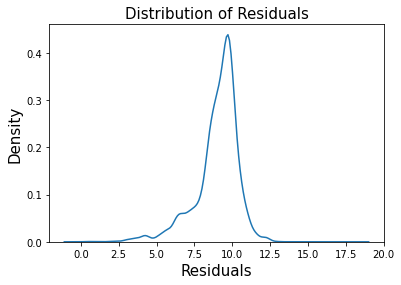

In [161]:
sns.distplot(mlr_model.resid,hist=False)

plt.title('Distribution of Residuals', fontsize = 15)
plt.xlabel('Residuals', fontsize = 15)
plt.ylabel('Density', fontsize = 15)

print("Skewness of the residuals: ", mlr_model.resid.skew())

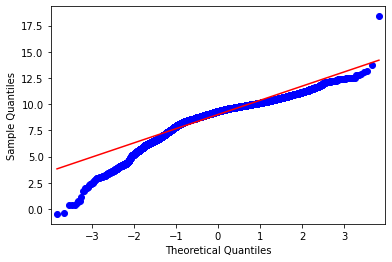

In [162]:
qqplot(mlr_model.resid,line='r')
plt.show()

In [163]:
# x_train.drop("intercept",axis=1,inplace=True)
new_train = x_train.copy()
new_test = x_test.copy()

In [164]:
display(x_train.head())

,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo engine
7808,-0.344135,0.374642,0.975797,0.615795,-0.793472,0.212073,0.985689,-0.426576,-0.599015,0.159765,0.160242,-0.28749,1.163418,-0.717521,-0.334262
16766,0.975616,-0.706692,-0.817229,0.615795,-1.347084,-0.355292,-0.751903,-0.426576,-0.599015,0.159765,0.160242,-0.28749,0.790596,0.727602,-0.334262
7285,1.282596,-0.166025,0.975797,0.615795,-1.347084,1.346803,0.566978,1.163112,-0.599015,-1.599316,0.160242,-0.28749,-1.259927,-0.717521,-0.334262
15712,-0.703590,0.194420,-0.817229,0.615795,-1.347084,-0.355292,0.904403,-0.426576,-0.599015,0.159765,0.160242,-0.28749,-0.141460,0.727602,-0.334262
16562,0.000000,-1.968248,-0.817229,0.615795,0.313751,0.779438,-1.347710,1.163112,1.633895,-1.599316,0.160242,-0.28749,0.790596,1.140495,-0.334262


In [165]:
from sklearn.linear_model import LinearRegression

In [166]:
linreg=LinearRegression()

In [167]:
linreg.fit(new_train,y_train)

LinearRegression()

In [168]:
# y_pred_train=linreg.predict(new_train)

In [169]:
# y_pred_test=linreg.predict(new_test)

In [170]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [171]:
# rmse_train=np.sqrt(mean_squared_error(y_test,y_pred_test))

In [172]:
# mae_train=mean_absolute_error(y_test,y_pred_test)

In [173]:
# print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred_test))
# print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred_test)))
# print("R squared Score is",r2_score(y_test,y_pred_test))

## **Forward Selection**

In [174]:
from mlxtend.feature_selection import SequentialFeatureSelector

In [175]:
linreg_forward=SequentialFeatureSelector(estimator=linreg,k_features=(5,10),
                                        forward=True,cv=10,
                                        scoring='r2')

In [176]:
sfs_forward=linreg_forward.fit(new_train,y_train)

In [177]:
print('Feature Selection using forward selection are : ',sfs_forward.k_feature_names_)
print('R-Squared : ', sfs_forward.k_score_)

Feature Selection using forward selection are :  ('Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Gear box type', 'Wheel', 'Turbo engine')
R-Squared :  0.1061458788519957


In [178]:
x_train.head()

,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo engine
7808,-0.344135,0.374642,0.975797,0.615795,-0.793472,0.212073,0.985689,-0.426576,-0.599015,0.159765,0.160242,-0.28749,1.163418,-0.717521,-0.334262
16766,0.975616,-0.706692,-0.817229,0.615795,-1.347084,-0.355292,-0.751903,-0.426576,-0.599015,0.159765,0.160242,-0.28749,0.790596,0.727602,-0.334262
7285,1.282596,-0.166025,0.975797,0.615795,-1.347084,1.346803,0.566978,1.163112,-0.599015,-1.599316,0.160242,-0.28749,-1.259927,-0.717521,-0.334262
15712,-0.703590,0.194420,-0.817229,0.615795,-1.347084,-0.355292,0.904403,-0.426576,-0.599015,0.159765,0.160242,-0.28749,-0.141460,0.727602,-0.334262
16562,0.000000,-1.968248,-0.817229,0.615795,0.313751,0.779438,-1.347710,1.163112,1.633895,-1.599316,0.160242,-0.28749,0.790596,1.140495,-0.334262


## **Backward Selection**

In [179]:
linreg_backward=SequentialFeatureSelector(estimator=linreg,k_features=(5,10),
                                         forward=False,cv=12,
                                         scoring='r2')

In [180]:
sfs_backward = linreg_backward.fit(new_train.values, y_train)

In [181]:
print('Feature Selection using backward selection are : ',sfs_backward.k_feature_names_)
print('R-Squared : ', sfs_backward.k_score_)

Feature Selection using backward selection are :  ('1', '5', '6', '8', '14')
R-Squared :  0.11927880176862742


In [182]:
from sklearn.feature_selection import RFE

In [183]:
rfe=RFE(estimator=linreg,n_features_to_select=8)
rfe.fit(new_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=8)

In [184]:
feat_index = pd.Series(data = rfe.ranking_, index = new_train.columns)

In [185]:
signi_feat_rfe = feat_index[feat_index==1].index

In [186]:
signi_feat_rfe

Index(['Prod. year', 'Category', 'Fuel type', 'Mileage', 'Gear box type',
       'Doors', 'Wheel', 'Color'],
      dtype='object')

In [187]:
from sklearn.model_selection import KFold,LeaveOneOut,cross_val_score

In [188]:
kf=KFold(n_splits=5)

In [189]:
def get_score(model,x_train_k,x_test_k,y_train_k,y_test_k):
    model.fit(x_train_k,y_train_k)
    x=model.score(x_train_k,y_train_k)
    return x

In [190]:
scores=[]
for i,j in kf.split(new_train):
    x_train_k,x_test_k,y_train_k,y_test_k=new_train.iloc[i],new_train.iloc[j],y_train.iloc[i],y_train.iloc[j]
    s=get_score(linreg,x_train_k,x_test_k,y_train_k,y_test_k)
    scores.append(s)

In [191]:
print('All Scores',scores,sep='\n')
print('Maximum Scores obtained : ',max(scores),sep='\n')
print('Minimum Scores obtained : ',min(scores),sep='\n')
print('Average Scores obtained : ',np.mean(scores),sep='\n')

All Scores
[0.0034437408234297973, 0.0033460775665284936, 0.2371507863285115, 0.0035213838398733266, 0.0034407835488183824]
Maximum Scores obtained : 
0.2371507863285115
Minimum Scores obtained : 
0.0033460775665284936
Average Scores obtained : 
0.0501805544214323


## **Stacked Model**

In [192]:
rdge = Ridge()

In [193]:
# class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
#     def __init__(self, base_models, meta_model, n_folds=5):
#         self.base_models = base_models
#         self.meta_model = meta_model
#         self.n_folds = n_folds
   
#     # We again fit the data on clones of the original models
#     def fit(self, X, y):
#         self.base_models_ = [list() for x in self.base_models]
#         self.meta_model_ = clone(self.meta_model)
#         kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
#         # Train cloned base models then create out-of-fold predictions
#         # that are needed to train the cloned meta-model
#         out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
#         for i, model in enumerate(self.base_models):
#             for train_index, holdout_index in kfold.split(X, y):
#                 instance = clone(model)
#                 self.base_models_[i].append(instance)
#                 instance.fit(X_train, y_train)
#                 y_pred = instance.predict(X[holdout_index])
#                 out_of_fold_predictions[holdout_index, i] = y_pred
                
#         # Now train the cloned  meta-model using the out-of-fold predictions as new feature
#         self.meta_model_.fit(out_of_fold_predictions, y)
#         return self
   
#     #Do the predictions of all base models on the test data and use the averaged predictions as 
#     #meta-features for the final prediction which is done by the meta-model
#     def predict(self, X):
#         meta_features = np.column_stack([
#             np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
#             for base_models in self.base_models_ ])
#         return self.meta_model_.predict(meta_features)

In [194]:
rdge = Ridge()
# lass = Lasso()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()

In [195]:
# lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=42))

# stacked_averaged_models = StackingAveragedModels(base_models = (rdge, rf,gb),
#                                                  meta_model = lasso)
# stacked_averaged_models.fit(x_train.values, y_train)

# y_pred3 = stacked_averaged_models.predict(x_test.values)

# print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred3))
# print("Mean Squared Error is",mean_squared_error(y_test,y_pred3))
# print("R squared Score is",r2_score(y_test,y_pred3))
# print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred3 +1) - np.log10(y_test +1)).mean() ** 0.5)

In [196]:
## **According to Feature Selection**

In [197]:

# sfs_forward.k_feature_names_

# x = train.loc[:,sfs_forward.k_feature_names_]
# x.head()

# X = x
# y = train_price

# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

# x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

## **Models**

In [198]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [199]:
x_train.head()

,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo engine
7808,-0.344135,0.374642,0.975797,0.615795,-0.793472,0.212073,0.985689,-0.426576,-0.599015,0.159765,0.160242,-0.28749,1.163418,-0.717521,-0.334262
16766,0.975616,-0.706692,-0.817229,0.615795,-1.347084,-0.355292,-0.751903,-0.426576,-0.599015,0.159765,0.160242,-0.28749,0.790596,0.727602,-0.334262
7285,1.282596,-0.166025,0.975797,0.615795,-1.347084,1.346803,0.566978,1.163112,-0.599015,-1.599316,0.160242,-0.28749,-1.259927,-0.717521,-0.334262
15712,-0.703590,0.194420,-0.817229,0.615795,-1.347084,-0.355292,0.904403,-0.426576,-0.599015,0.159765,0.160242,-0.28749,-0.141460,0.727602,-0.334262
16562,0.000000,-1.968248,-0.817229,0.615795,0.313751,0.779438,-1.347710,1.163112,1.633895,-1.599316,0.160242,-0.28749,0.790596,1.140495,-0.334262


In [200]:
x_test.head()

,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo engine
736,-1.708489,0.554865,-1.175834,-1.623918,1.420974,-1.036129,-0.882218,-0.426576,-0.599015,0.159765,0.160242,-0.28749,0.790596,-1.130414,-0.334262
8674,0.000000,-2.508915,-0.100019,0.615795,-1.347084,0.665965,-1.599856,1.163112,0.517440,1.918846,-4.480204,-0.28749,0.604185,0.314710,2.991661
5971,0.000000,-2.689137,0.975797,-1.623918,0.867362,-0.582237,0.834113,2.752800,0.517440,1.918846,0.160242,-0.28749,-0.327871,0.314710,-0.334262
1957,-0.711461,0.554865,-0.817229,0.615795,-1.347084,-0.355292,-0.093719,-0.426576,-0.599015,0.159765,0.160242,-0.28749,-0.141460,0.727602,-0.334262
11075,-0.207699,1.095532,-0.817229,0.615795,0.867362,-0.809183,-1.048049,-0.426576,-0.599015,0.159765,0.160242,-0.28749,1.163418,0.727602,-0.334262


In [201]:
x_train

,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo engine
7808,-0.344135,0.374642,0.975797,0.615795,-0.793472,0.212073,0.985689,-0.426576,-0.599015,0.159765,0.160242,-0.287490,1.163418,-0.717521,-0.334262
16766,0.975616,-0.706692,-0.817229,0.615795,-1.347084,-0.355292,-0.751903,-0.426576,-0.599015,0.159765,0.160242,-0.287490,0.790596,0.727602,-0.334262
7285,1.282596,-0.166025,0.975797,0.615795,-1.347084,1.346803,0.566978,1.163112,-0.599015,-1.599316,0.160242,-0.287490,-1.259927,-0.717521,-0.334262
15712,-0.703590,0.194420,-0.817229,0.615795,-1.347084,-0.355292,0.904403,-0.426576,-0.599015,0.159765,0.160242,-0.287490,-0.141460,0.727602,-0.334262
16562,0.000000,-1.968248,-0.817229,0.615795,0.313751,0.779438,-1.347710,1.163112,1.633895,-1.599316,0.160242,-0.287490,0.790596,1.140495,-0.334262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-0.079135,1.275754,-0.817229,0.615795,0.867362,-0.809183,-1.499543,-0.426576,-0.599015,0.159765,0.160242,-0.287490,0.604185,0.727602,-0.334262
11964,-0.790174,1.275754,0.975797,0.615795,-0.793472,0.212073,-1.230662,-0.426576,-0.599015,0.159765,0.160242,-0.287490,1.163418,-0.717521,-0.334262
5390,0.012697,0.554865,-0.817229,0.615795,-1.347084,0.779438,-0.350217,1.163112,-0.599015,-1.599316,0.160242,-0.287490,1.163418,-1.543306,-0.334262
860,0.000000,-1.067136,0.975797,0.615795,0.867362,0.212073,0.246603,1.163112,1.633895,1.918846,0.160242,3.478382,1.163418,-0.717521,-0.334262


In [202]:
x_test

,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo engine
736,-1.708489,0.554865,-1.175834,-1.623918,1.420974,-1.036129,-0.882218,-0.426576,-0.599015,0.159765,0.160242,-0.28749,0.790596,-1.130414,-0.334262
8674,0.000000,-2.508915,-0.100019,0.615795,-1.347084,0.665965,-1.599856,1.163112,0.517440,1.918846,-4.480204,-0.28749,0.604185,0.314710,2.991661
5971,0.000000,-2.689137,0.975797,-1.623918,0.867362,-0.582237,0.834113,2.752800,0.517440,1.918846,0.160242,-0.28749,-0.327871,0.314710,-0.334262
1957,-0.711461,0.554865,-0.817229,0.615795,-1.347084,-0.355292,-0.093719,-0.426576,-0.599015,0.159765,0.160242,-0.28749,-0.141460,0.727602,-0.334262
11075,-0.207699,1.095532,-0.817229,0.615795,0.867362,-0.809183,-1.048049,-0.426576,-0.599015,0.159765,0.160242,-0.28749,1.163418,0.727602,-0.334262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12026,-0.682600,0.915309,0.975797,-1.623918,0.867362,-1.036129,-1.533908,-0.426576,1.633895,0.159765,0.160242,-0.28749,-0.700694,-0.717521,2.991661
17893,0.000000,-1.427581,-0.100019,-1.623918,-1.347084,0.098600,1.270687,-0.426576,0.517440,1.918846,0.160242,-0.28749,1.163418,0.314710,2.991661
5339,3.935216,-0.166025,0.975797,0.615795,0.867362,4.410573,1.558955,2.752800,-0.599015,1.918846,0.160242,-0.28749,1.163418,-0.717521,-0.334262
11859,-0.585520,-0.166025,0.975797,0.615795,0.867362,-0.809183,-0.470221,-0.426576,-0.599015,0.159765,0.160242,-0.28749,1.163418,0.727602,-0.334262


In [203]:
lr=LinearRegression()
lr.fit(x_train,y_train)


LinearRegression()

In [204]:
y_pred = lr.predict(x_test)


print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R squared Score is",r2_score(y_test,y_pred))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)

Mean Absolute Error is 12931.812791427783
Mean Squared Error is 18240.921999406724
R squared Score is -0.06782686239331692
Mean Absolute Logarithmic Error is 0.729066334019895


## **LIghtGBM**

In [205]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

In [230]:
rf = RandomForestRegressor(max_depth = 6,
        n_estimators= 60)  

rf.fit(x_train,y_train)

y_pred01 = rf.predict(x_test)

print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred01))
print("Mean Squared Error is",mean_squared_error(y_test,y_pred01))
print("R squared Score is",r2_score(y_test,y_pred2))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred01 +1) - np.log10(y_test +1)).mean() ** 0.5)

Mean Absolute Error is 10791.304787315574
Mean Squared Error is 31564362030.211308
R squared Score is -76.96927084723187
Mean Absolute Logarithmic Error is 0.6136349854262129


In [231]:
xgb = XGBRegressor(max_depth = 9,
    learning_rate=0.5,
        silent= 1, 
        objective= 'reg:linear',  
        eval_metric= 'rmse',
        )

xgb.fit(x_train,y_train)

y_pred0 = xgb.predict(x_test)

print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred0))
print("Mean Squared Error is",mean_squared_error(y_test,y_pred0))
print("R squared Score is",r2_score(y_test,y_pred2))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred0 +1) - np.log10(y_test +1)).mean() ** 0.5)

[15:29:15] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:15] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Mean Absolute Error is 8777.851779597464
Mean Squared Error is 52970417467.89068
R squared Score is -76.96927084723187
Mean Absolute Logarithmic Error is 0.44926300752693327


In [206]:
model_lgb = lgb.LGBMRegressor(objective='regression',n_estimators=720)
model_lgb.fit(x_train, y_train)

y_pred2 = model_lgb.predict(x_test)

print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred2))
print("Mean Squared Error is",mean_squared_error(y_test,y_pred2))
print("R squared Score is",r2_score(y_test,y_pred2))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred2 +1) - np.log10(y_test +1)).mean() ** 0.5)

Mean Absolute Error is 17588.372477267483
Mean Squared Error is 24294960845.234604
R squared Score is -76.96927084723187
Mean Absolute Logarithmic Error is 0.6152269039748771


In [233]:
y_ens = (0.33*y_pred01 + 0.34*y_pred0  + 0.33* y_pred2)
print("Mean Absolute Error is",mean_absolute_error(y_test,y_ens))
print("Mean Squared Error is",mean_squared_error(y_test,y_ens))
print("R squared Score is",r2_score(y_test,y_ens))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_ens +1) - np.log10(y_test +1)).mean() ** 0.5)

Mean Absolute Error is 11529.099861073117
Mean Squared Error is 27493534669.342285
R squared Score is -87.23438180606
Mean Absolute Logarithmic Error is 0.5732873013404947


## **Ridge and Lasso**

In [207]:
from sklearn.linear_model import Ridge,Lasso

In [208]:
pipe = Pipeline([('classifier',Ridge())])
grid_param = [{"classifier__alpha": [0.1,0.5,1,100],
               "classifier__solver":['auto', 'svd', 'cholesky'],
               "classifier__fit_intercept":[True,False]}]

gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=3,n_jobs=-1)
best_model = gridsearch.fit(x_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.6s finished


In [209]:
gridsearch.best_estimator_

Pipeline(steps=[('classifier', Ridge(alpha=100))])

In [210]:
y_pred = best_model.predict(x_test)
print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R squared Score is",r2_score(y_test,y_pred))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)

Mean Absolute Error is 12904.06926950364
Mean Squared Error is 18207.979309236274
R squared Score is -0.06397340312486932
Mean Absolute Logarithmic Error is 0.7271019653194059


## **Lasso**

In [211]:
pipe = Pipeline([('classifier',Lasso())])
grid_param = [{"classifier__alpha": [0,0.01,0.1,0.5,1],
               "classifier__selection":['cyclic', 'random'],
               "classifier__fit_intercept":[True,False]}]

gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=3,n_jobs=-1)
best_model = gridsearch.fit(x_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished


In [212]:
y_pred = best_model.predict(x_test)
print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R squared Score is",r2_score(y_test,y_pred))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)

Mean Absolute Error is 12930.842644690825
Mean Squared Error is 18240.03584368068
R squared Score is -0.06772311348154769
Mean Absolute Logarithmic Error is 0.7286626452194513


## **Gradient Boosting**

In [234]:
from sklearn.ensemble import GradientBoostingRegressor
gradboost = GradientBoostingRegressor(random_state=0)
gradboost.fit(x_train,y_train)
gradboost.predict(x_test)


y_pred = gradboost.predict(x_test)
print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R squared Score is",r2_score(y_test,y_pred))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)

Mean Absolute Error is 12658.113228442211
Mean Squared Error is 42218.992611525544
R squared Score is -4.720355270708423
Mean Absolute Logarithmic Error is 0.6622064094170341


## **Lasso**

In [214]:
# pipe = Pipeline([('classifier',Lasso())])
# grid_param = [{"classifier__alpha": [0,0.01,0.1,0.5,1],
#                "classifier__selection":['cyclic', 'random'],
#                "classifier__fit_intercept":[True,False]}]

# gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=3,n_jobs=-1)
# best_model = gridsearch.fit(x_train,y_train)
# y_pred = best_model.predict(x_test)
# print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
# print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
# print("R squared Score is",r2_score(y_test,y_pred))
# print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)


## **Ridge**

In [215]:
# pipe = Pipeline([('classifier',Ridge())])
# grid_param = [{"classifier__alpha": [0.1,0.5,1,100],
#                "classifier__solver":['auto', 'svd', 'cholesky'],
#                "classifier__fit_intercept":[True,False]}]

# gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=3,n_jobs=-1)
# best_model = gridsearch.fit(x_train,y_train)


# y_pred = best_model.predict(x_test)
# print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
# print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
# print("R squared Score is",r2_score(y_test,y_pred))
# print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)


## **Gradient Boosting**

In [216]:
# gradboost = GradientBoostingRegressor(random_state=0)
# gradboost.fit(x_train,y_train)
# gradboost.predict(x_test)


# y_pred = gradboost.predict(x_test)
# print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
# print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
# print("R squared Score is",r2_score(y_test,y_pred))
# print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)

In [217]:
# x_poly_check  = train.copy()

In [218]:
# # Fitting Polynomial Regression to the dataset
# from sklearn.preprocessing import PolynomialFeatures
  
# poly = PolynomialFeatures(degree = 3)
# X_poly = poly.fit_transform(x_poly_check)


In [219]:
# x_train,x_test,y_train,y_test=train_test_split(X_poly,y,test_size=0.2,random_state=42)

## **Ridge**

In [220]:
# pipe = Pipeline([('classifier',Ridge())])
# grid_param = [{"classifier__alpha": [0.1,0.5,1,100],
#                "classifier__solver":['auto', 'svd', 'cholesky'],
#                "classifier__fit_intercept":[True,False]}]

# gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=3,n_jobs=-1)
# best_model = gridsearch.fit(x_train,y_train)


# y_pred = best_model.predict(x_test)
# print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
# print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
# print("R squared Score is",r2_score(y_test,y_pred))
# print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)


## **Lasso**

In [221]:
# pipe = Pipeline([('classifier',Lasso())])
# grid_param = [{"classifier__alpha": [0,0.01,0.1,0.5,1],
#                "classifier__selection":['cyclic', 'random'],
#                "classifier__fit_intercept":[True,False]}]

# gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=3,n_jobs=-1)
# best_model = gridsearch.fit(x_train,y_train)
# y_pred = best_model.predict(x_test)
# print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
# print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
# print("R squared Score is",r2_score(y_test,y_pred))
# print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)


## **Linear Regression**

In [222]:
# lr=LinearRegression()
# lr.fit(x_train,y_train)
# lr.predict(x_test)

# y_pred = lr.predict(x_test)
# print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
# print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
# print("R squared Score is",r2_score(y_test,y_pred))
# print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)
